# Minggu 6: Epipolar Geometry dan Structure from Motion

In [2]:
# untuk menjalankan fungsi detektor SIFT, SURF dan ORB pada OpenCV,
# terlebih dahulu uninstall OpenCV versi 4 yang secara default terinstall
# pada Google Colab, kemudian lakukan kembali instalasi versi OpenCV 
# yang lebih rendah sehingga fungsi SIFT dkk dapat digunakan

!pip uninstall opencv-python -y
# downgrade OpenCV a bit since some none-free features are not avilable
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall


Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 1.3MB/s 
     |████████████████████████████████| 20.2MB 129kB/s 
ERROR: tensor2tensor 1.14.1 requires opencv-python, which is not installed.
ERROR: tensorflow-model-optimization 0.2.1 requires enum34~=1.1, which is not installed.
ERROR: stable-baselines 2.2.1 requires opencv-python, which is not installed.
ERROR: imgaug 0.2.9 requires opencv-python, which is not installed.
ERROR: dopamine-rl 1.0.5 requires opencv-python>=3.4.1.15, which is not installed.
ERROR: albumentations 0.1.12 requires opencv-python, which is not installed.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow~=2.1.0, but you'll have tensorflow 1.15.0 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but yo

## Epipolar Geometry

Latihan berikut adalah untuk melakukan penentuan epipolar geometry pada pasangan foto stereo. Gunakan data masing-masing untuk latihan ini

Lakukan perubahan, misalnya menggunakan feature detector yang berbeda, untuk melihat perubahan penggunaannya (lihat materi minggu sebelumnya)




Fundamental Matrix:
[[-1.05538056e-06  1.96820313e-05  1.42447775e-02]
 [-1.18441942e-05 -4.41428981e-07 -1.64827765e-01]
 [-1.66642389e-02  1.58138698e-01  1.00000000e+00]]


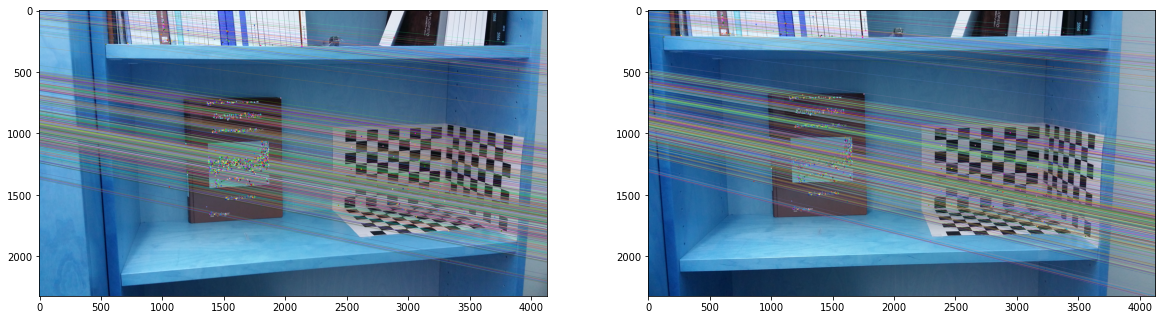

In [2]:
# contoh rekonstruksi epipolar geometry dan penentuan fundamental matrix 
# dengan menggunakan algoritma rekonstruksi SIFT

import cv2
import numpy as np
from matplotlib import pyplot as plt
img1 = cv2.imread('im1.jpg') #queryimage # left image
gray1= cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)

img2 = cv2.imread('im2.jpg') #trainimage # right image
gray2= cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(gray1,None)
kp2, des2 = sift.detectAndCompute(gray2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = []
pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)


# mencari fundamental matrix untuk rekonstruksi epipolar geometry
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

print('Fundamental Matrix:')
print(F)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

# gambar garis 
def drawlines(gray1,gray2,lines,pts1,pts2):
    r,c,_ = gray1.shape
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(np.int64, [0, -r[2]/r[1] ])
        x1,y1 = map(np.int64, [c, -(r[2]+r[0]*c)/r[1] ])
        gray1 = cv2.line(gray1, (x0,y0), (x1,y1), color,1)
        gray1 = cv2.circle(gray1,tuple(pt1),5,color,-1)
        gray2 = cv2.circle(gray2,tuple(pt2),5,color,-1)
    return gray1,gray2

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)


# fungsi di atas hanya menggambar garis untuk tiap keypoint yang berada pada epilines
# bandingkan dengan hasil yang diperoleh minggu lalu tanpa menggunakan fungsi
# cv2.computeCorrespondEpilines() seperti di atas


# perbesar ukuran hasil plotting 
plt.rcParams["figure.figsize"] = (20,20)


# plot hasilnya
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

## Disparity Map Estimation

Latihan berikut untuk menghitung estimasi disparity. Dalam contoh, disparity dihitung menggunakan algoritma StereoBM.

Gunakan gambar masing-masing dan rubah parameternya untuk melihat perubahan yang terjadi.


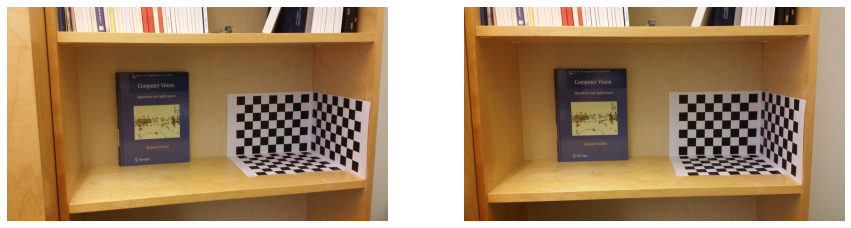

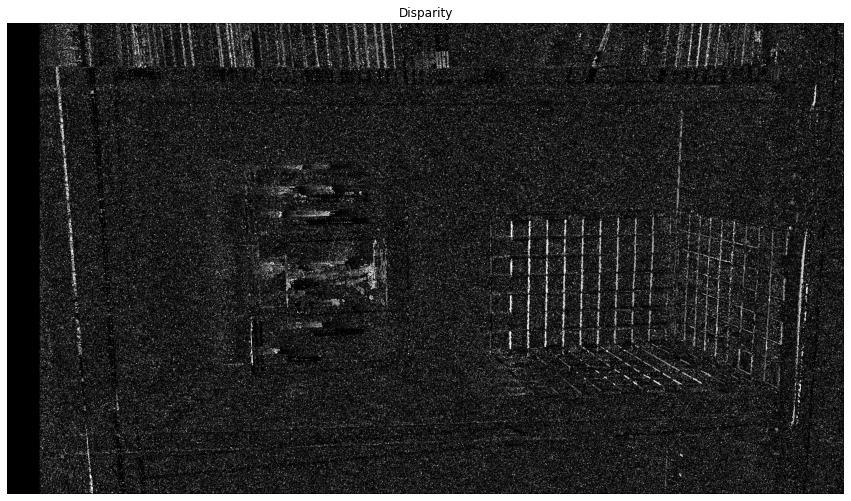

In [8]:
# menghitung disparity

# skala untuk memperkecil ukuran foto pada saat diproses
# sc = 0.25 berarti ukuran gambar diperkecil menjadi seperempatnya
# (di Agisoft sama dengan pengaturan 'lowest')
sc=1 # di Agisoft: high

# baca gambar, perkecil ukuran sesuai skala
imgL = cv2.resize(cv2.imread('im1.jpg',0), (0,0), fx=sc, fy=sc)  
imgR = cv2.resize(cv2.imread('im2.jpg',0), (0,0), fx=sc, fy=sc) 
imgL_col = cv2.resize(cv2.imread('im1.jpg'), (0,0), fx=sc, fy=sc) 
imgR_col = cv2.resize(cv2.imread('im2.jpg'), (0,0), fx=sc, fy=sc) 


# Menampilkan gambar pada plot
plt.figure(figsize=[15,15])
plt.subplot(121)
plt.imshow(imgL_col[:,:,[2,1,0]])
plt.axis('off')
plt.subplot(122)
plt.imshow(imgR_col[:,:,[2,1,0]])
plt.axis('off')


# Menghitung diparity dengan algoritma StereoBM yang disediakan OpenCV
# rubah nilai disparity untuk melihat pengaruhnya
stereo = cv2.StereoBM_create(
    #numDisparities=16*10, 
    numDisparities=160,  # angka disparity harus bisa dibagi 16. sehingga lebih mudah kalau dinyatakan dalam perkalian 16
    blockSize=5
    )
disparity = stereo.compute(imgL,imgR)


# Menampilkan disparity
plt.figure(figsize=[15,15])
plt.imshow(disparity,'gray')
plt.axis('off')
plt.title('Disparity')
#ndistp=cv2.guidedFilter(imgL, disparity, 9, 4,0.1)

# Calibration data
baseline=17.8089 #cm 
f_length=2826.171*sc #pixels
c_point=np.array([1415.97,965.806])*sc # pixels

# Get depth from disparity
point=np.zeros([np.count_nonzero(disparity>1),6])
ind=0
for i in range(np.shape(disparity)[0]):
    for j in range(np.shape(disparity)[1]):
        if disparity[i,j]>1:
            # Save point information into point cloud
            # [pixel_x,pixel_y,disparity,color]
            point[ind,0:3]=j,i,disparity[i,j]
            point[ind,3:6]=imgL_col[i,j]/255.0
            ind+=1


# Z=baseline*focal/disparity
# openCV disparity is (16*actual_disparity). This depends on the algorithm.
# It is in order to use signed shorts and keep good subpixel accuracy.
point[:,2]=baseline*f_length/(point[:,2]/16.0)
#X=Z*(pixel_u-center_u)/focal
point[:,0]=point[:,2]*(point[:,0]-c_point[0])/f_length
#Y=Z*(pixel_v-center_v)/focal
point[:,1]=-point[:,2]*(point[:,1]-c_point[1])/f_length

# Delete points on the far background
inl=(point[:,2]<2000)
point=point[inl,:]

plt.show()